In [1]:
import warnings
from dataclasses import replace
import numpy as np
from tqdm import tqdm

from scripts.helpers import run_experiment
from scripts.matching import *
from scripts.plot import *
from scripts.propensity import get_propensity_scores
from variables.labels import *
from variables.variables import *

warnings.filterwarnings("ignore")

In [2]:
cfg = replace(
    BASE_CONFIG,
    method='quantile',
    limit=None,
    quantile=0.3
)
print(f"Running analysis of {cfg.__dict__['quantile']} quantile")

Running analysis of 0.3 quantile


In [3]:
from pathlib import Path
import pandas as pd

log_dir = Path(matching_folder_path_quantile)
log_dir.mkdir(parents=True, exist_ok=True)
log_csv_path = log_dir / "matching_meta_log.csv"
df_dir = Path(matching_df_folder_path)
df_dir.mkdir(parents=True, exist_ok=True)
meta_rows = []

for exposure in tqdm(EXPOSURES):
    df, kwargs, X, shap_values = get_propensity_scores(
        exposure=exposure,
        config=cfg.__dict__,
        variables=variable_config,
        file=DATAFRAME_PATH,
    )
    exposure_baseline = exposure.split("_target_day")[0]
    results_df, matched_df, balance_df, meta = estimate_ate_matching_pipeline_cuped(
        df=df,
        variable_config=variable_config,
        treat_col="treated",
        ps_col="calibrated_scores_logreg",
        match_covariates=["gender", "bmi",], 
        caliper=0.15,
        replace=False,
        alpha=0.05,
        seed=0,
    )
    results_df.to_csv(f"{df_dir}/{exposure_baseline}_results.csv")
    balance_df.to_csv(f"{df_dir}/{exposure_baseline}_balance.csv")

    meta_rows.append({
        "exposure": exposure,
        "exposure_baseline": exposure_baseline,
        "n_pairs": meta.get("n_pairs", pd.NA),
        "n_treated_matched": meta.get("n_treated_matched", pd.NA),
        "n_controls_matched": meta.get("n_controls_matched", pd.NA),
        "unique_controls_used": meta.get("unique_controls_used", pd.NA),
        "controls_reused": meta.get("controls_reused", pd.NA),
        "mean_abs_SMD_post": meta.get("mean_abs_SMD_post", pd.NA),
        "median_abs_SMD_post": meta.get("median_abs_SMD_post", pd.NA),
        "p75_abs_SMD_post": meta.get("p75_abs_SMD_post", pd.NA),
        "max_abs_SMD_post": meta.get("max_abs_SMD_post", pd.NA),
        "median_abs_SMD_post_OK": meta.get("median_abs_SMD_post_OK", pd.NA),
        "asmd_fail_count": meta.get("asmd_fail_count", pd.NA),
        "asmd_fail_features": meta.get("asmd_fail_features", ""),
        "caliper": meta.get("caliper", pd.NA),
        "replace": meta.get("replace", pd.NA),
        "smd_threshold": meta.get("smd_threshold", pd.NA),
        "seed": meta.get("seed", pd.NA),
        "match_covariates": meta.get("match_covariates", ""),
    })

    out_path = matching_plot_error_bars_new(
        df_bootstrap=results_df,
        treated_title=exposure_baseline,
        figsize=(10,8),
        dir=None,
        labels_dict=labels_dict,
        diet_short_names_mapping=diet_full_names_mapping,
        target_title="Treatment",
        alpha=0.05,
        out_dir=matching_folder_path_quantile,
    )

meta_log_df = pd.DataFrame(meta_rows)

100%|██████████| 27/27 [07:02<00:00, 15.66s/it]


In [4]:
def highlight_bad_smd(val):
    return 'background-color: #ffcccc' if val > 0.15 else ''

meta_subset = meta_log_df[[
    "exposure_baseline", "n_pairs", 
    "mean_abs_SMD_post", "max_abs_SMD_post",
    "asmd_fail_count",
]].sort_values(by="max_abs_SMD_post")

meta_subset.style.applymap(
    highlight_bad_smd,
    subset=["max_abs_SMD_post"]
)

,exposure_baseline,n_pairs,mean_abs_SMD_post,max_abs_SMD_post,asmd_fail_count
1,furits_and_veggies_energy_ratio,298,0.029777,0.079804,0
10,prot_pct,300,0.035675,0.100203,1
9,unique_plant_based_foods_count,293,0.054628,0.106282,1
0,plant_based_whole_foods_ratio,267,0.058081,0.120688,4
3,whole_dairy_categories_ratio,310,0.058090,0.123703,3
24,eating_window_h,303,0.051218,0.124828,1
25,caffeine_late_mg,469,0.049884,0.144503,1
26,night_calories_pct,329,0.076110,0.144639,6
8,fiber_density_energy,282,0.072306,0.149427,3
11,fat_pct,297,0.065963,0.149578,4


In [5]:
columns = [
    'fiber_density_energy',
    'hours_to_sleep',
    'plant_based_whole_foods_ratio',
    'processed_categories_ratio',
    'furits_and_veggies_energy_ratio',
    'prot_pct',
    'unique_plant_based_foods_count',
    'whole_dairy_categories_ratio',
    'night_calories_pct',
    'caffeine_late_mg',
    'eating_window_h'
]

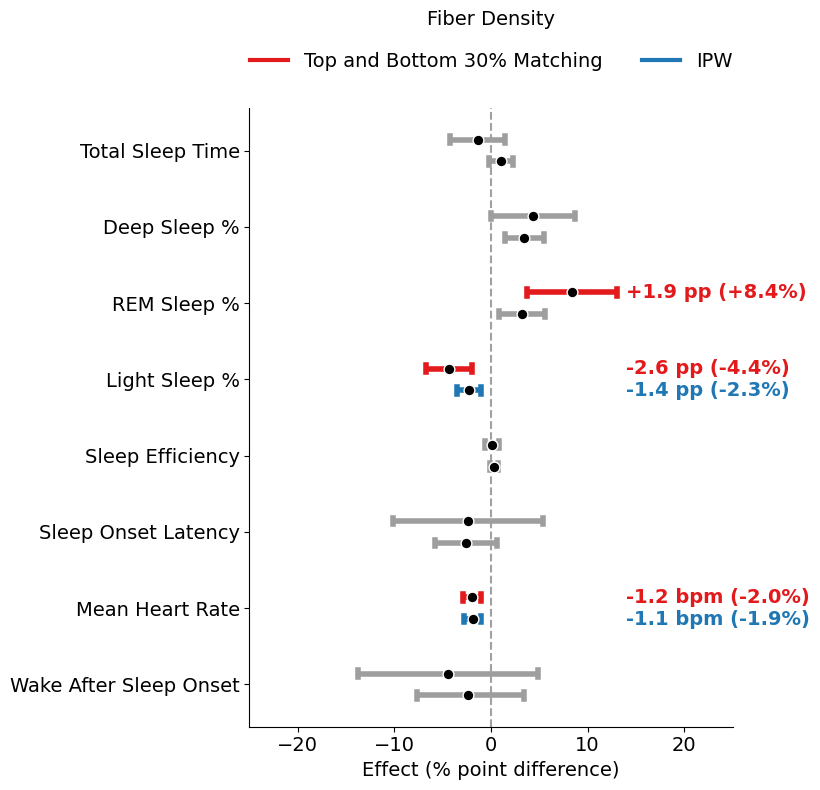

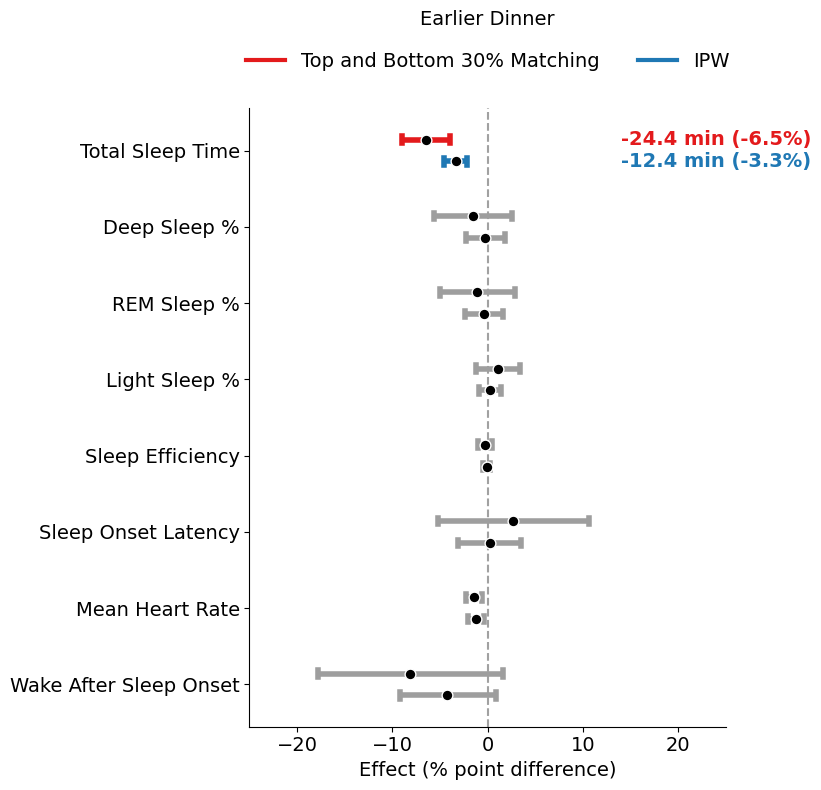

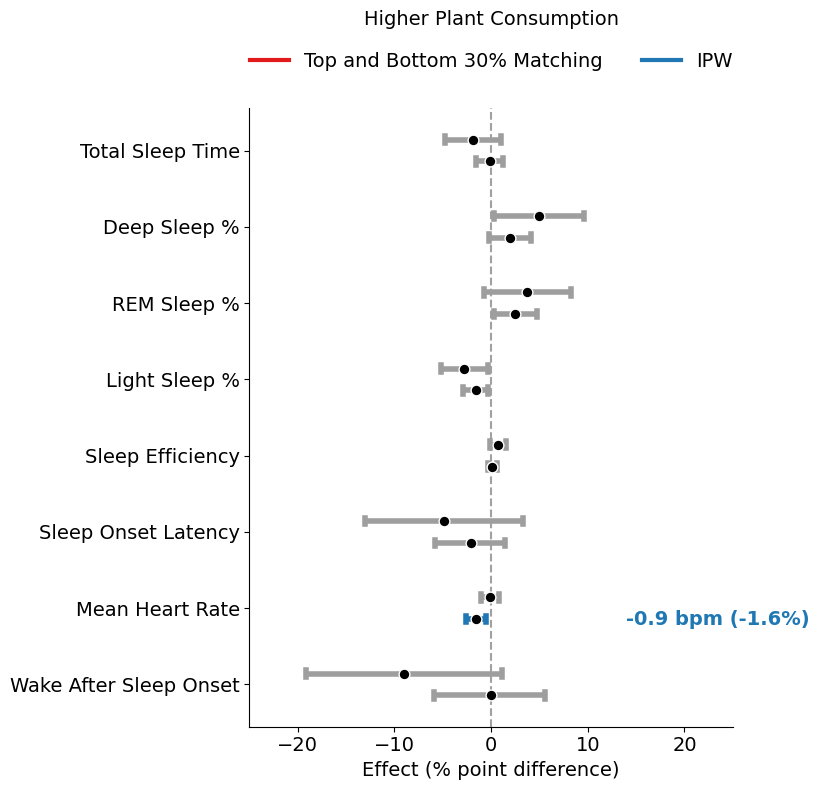

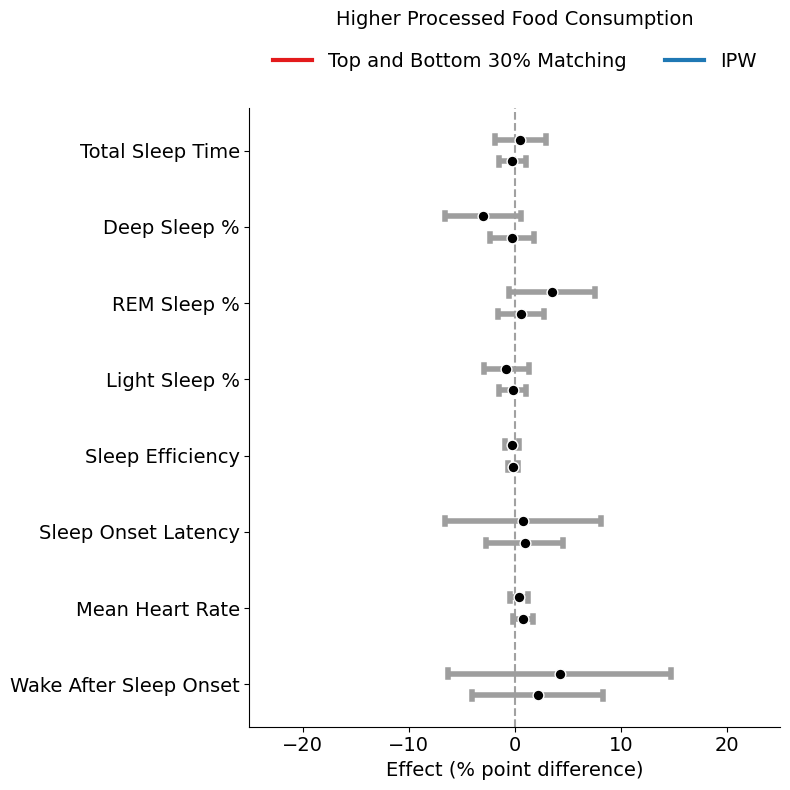

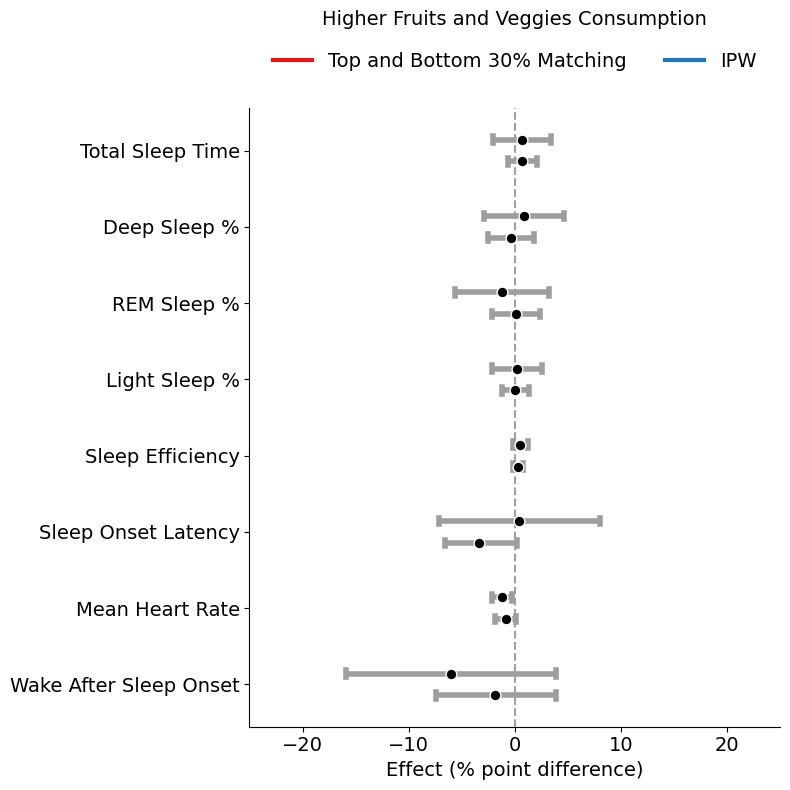

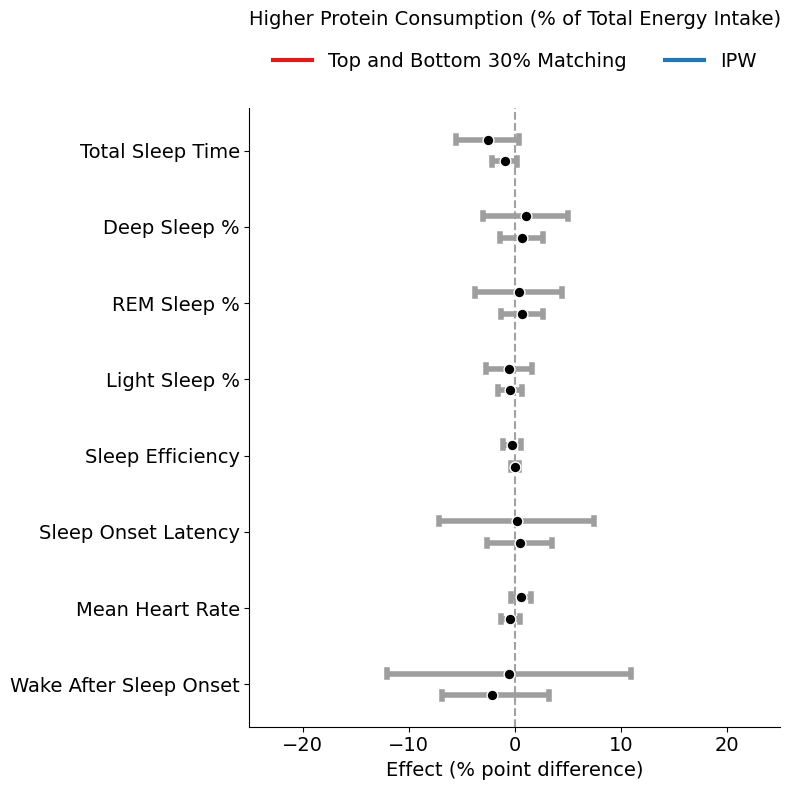

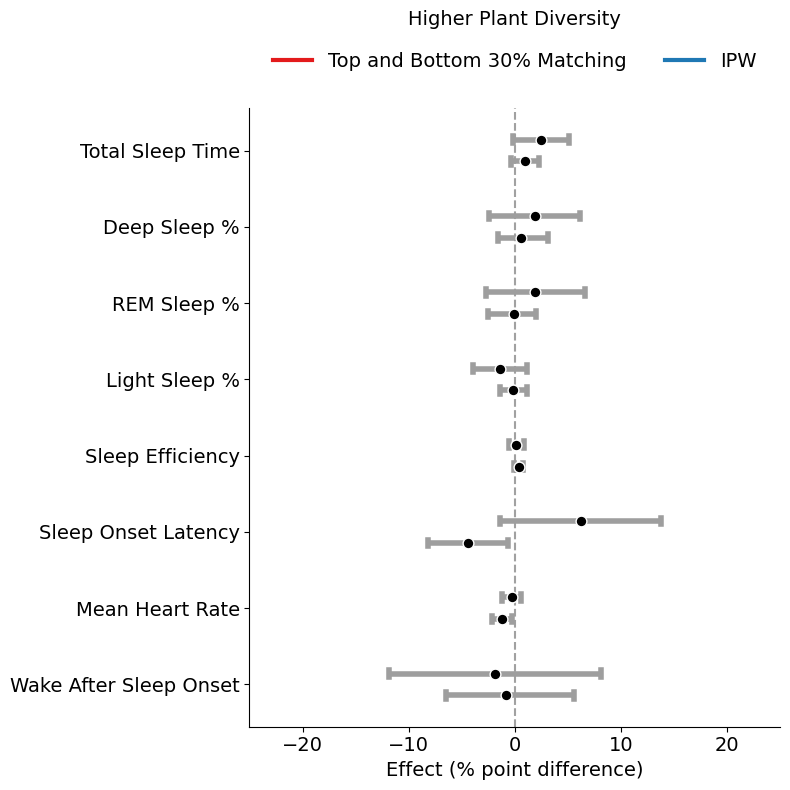

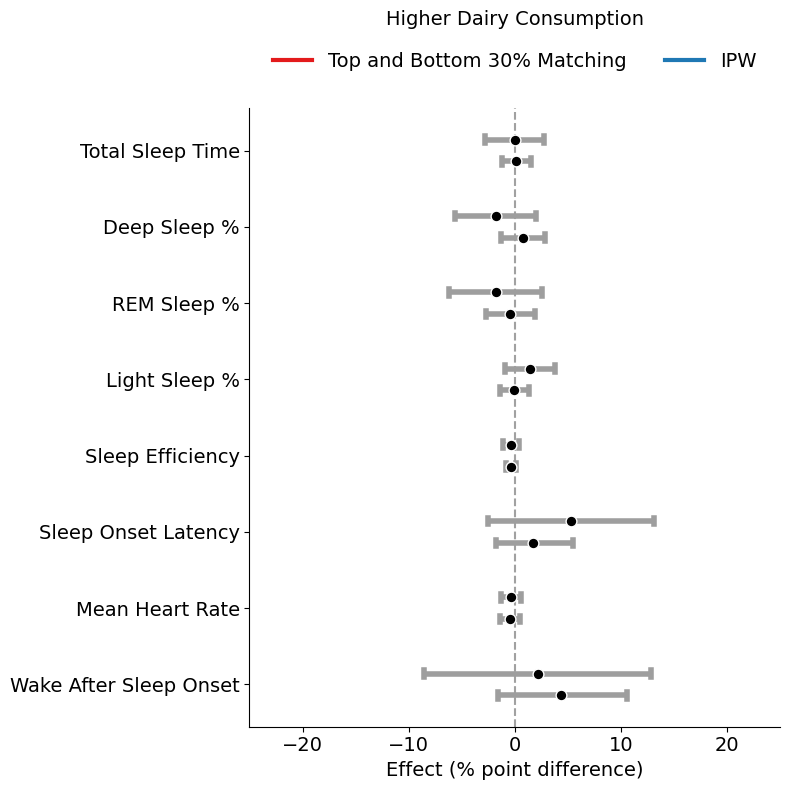

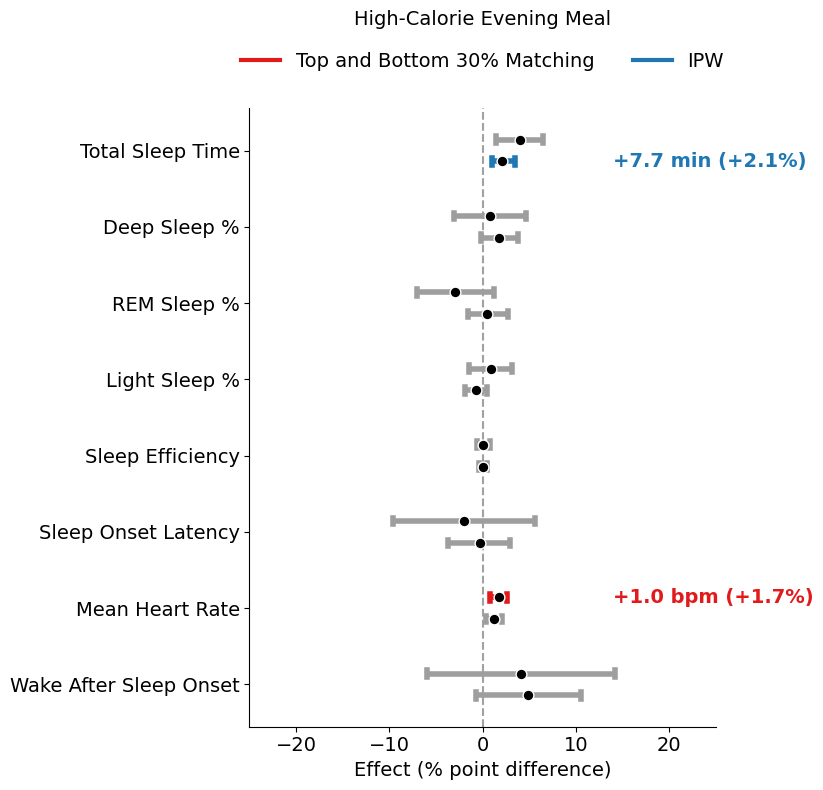

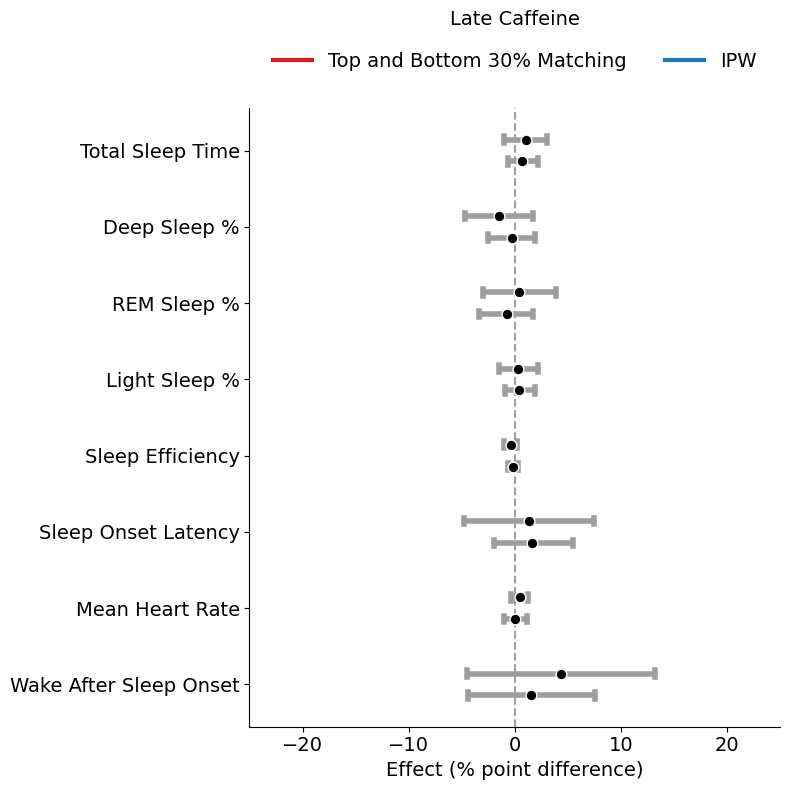

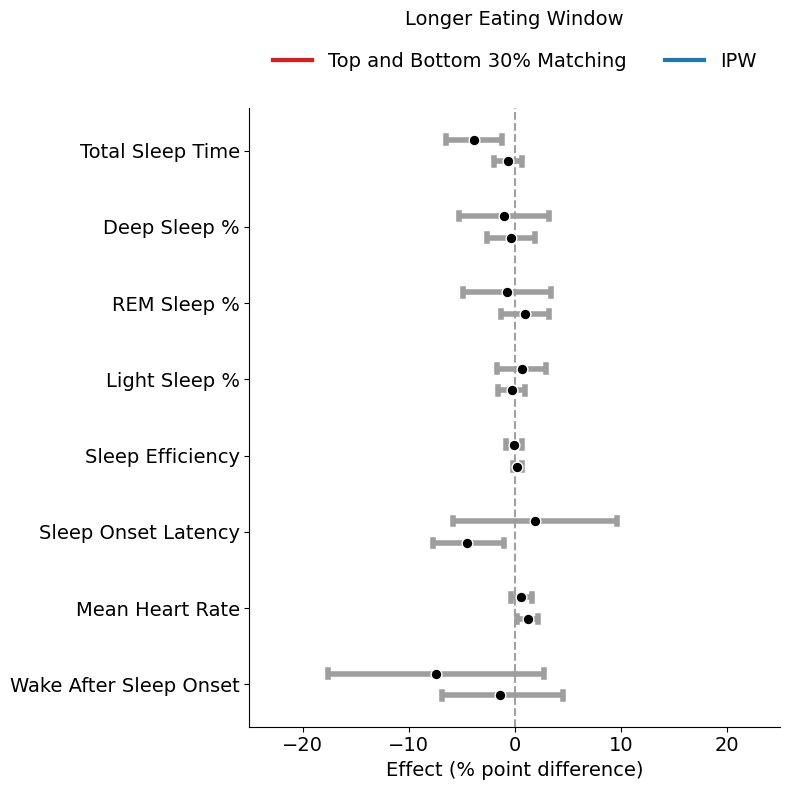

In [7]:
for c in columns:
    fig, ax = plot_combined_matching_ipw_results(
        c, 
        labels_dict=labels_dict,
        annotation_dict=annotation_dict,
        diet_full_names_mapping=diet_full_names_mapping
        )
    fig.show()